# GDP Growth Rate Regression

This notebook utilizes a neural network to predict the GDP growth rate based on transportation freight data that is published by the US Department of Transportation Bureau of Transportation Statistics.

An accompanying report for this notebook is available at:<br/>
https://github.com/schkotty/Data-Science/blob/master/GDP-Predictor/GDP-Regression-NN-Report.pdf

## Setup the Environment

In [1]:
#Import needed libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras import regularizers
from keras import models
from keras import layers

Using TensorFlow backend.


## Get and Prep the Data

I am using transportation data and GDP data that is published by the US government.  This step produces a data set that has transporation inputs and GDP data.

In [2]:
#Read in the transportation data, monthly seasonally adjusted
tsi_data = pd.read_excel(".\data\Input_SeasonalData_TSI.xlsx", header=2)

#look at the data types that were inferred by Pandas during import.
tsi_data.dtypes

OBS_DATE                   datetime64[ns]
RAIL_FRT_CARLOADS_D11               int64
RAIL_FRT_INTERMODAL_D11             int64
WATERBORNE_D11                    float64
TRUCK_D11                         float64
AIR_RTMFM_D11                       int64
TSI                               float64
dtype: object

In [3]:
#Return a listing of the data
tsi_data.head()

,OBS_DATE,RAIL_FRT_CARLOADS_D11,RAIL_FRT_INTERMODAL_D11,WATERBORNE_D11,TRUCK_D11,AIR_RTMFM_D11,TSI
0,2000-01-01,1422442,764756,55.4,80.3,2466950,105.3
1,2000-02-01,1425882,767958,48.6,79.8,2521852,104.4
2,2000-03-01,1411458,763858,52.5,74.1,2489787,99.2
3,2000-04-01,1400311,764144,50.8,72.8,2557332,98.1
4,2000-05-01,1405169,763843,52.5,73.0,2527821,98.6


In [4]:
#Read in the real gdp growth rates,seasonally adjusted, quarterly data with quarterly growth rates
gdp_data = pd.read_excel(".\data\Input_GDP_st_louis_fed_quarterly_change.xlsx")

# The gdp qtr growth rate from the file is in the format of 10% = 10.  We need to format it like
# the data below, with a format of 10% = 0.10.  Divide by 100 so the format will be consistent.
# This calculation should be kept in the same code block as the read from the file to ensure that
# this calculation is idempotent.
gdp_data.Real_gdp_qtr_growth = gdp_data.Real_gdp_qtr_growth/100.0

#look at the data types that were inferred by Pandas during import.
gdp_data.dtypes

observation_date       datetime64[ns]
Real_gdp_qtr_growth           float64
dtype: object

In [5]:
#Disply a listing of the data
gdp_data.head()

,observation_date,Real_gdp_qtr_growth
0,2000-01-01,0.015
1,2000-04-01,0.075
2,2000-07-01,0.005
3,2000-10-01,0.025
4,2001-01-01,-0.011


In [6]:
# Create a merged dataset based on the date, bringing together the transportation and GDP data. 
merged_data = pd.merge(tsi_data, gdp_data, how='left', left_on='OBS_DATE', right_on='observation_date')

# We now have 2 date columns with different names. Drop one of the date columns.
merged_data = merged_data.drop(['observation_date'], axis=1) #pandas can drop rows or columns, axis=1 indicates columns

#Forward fill the gdp data so that a quarterly gdp value will be used for 3 rows, with each row being a month.
#limit it only fill in 2 consective missing values.
merged_data['Real_gdp_qtr_growth'] = merged_data['Real_gdp_qtr_growth'].fillna(method='ffill', limit=2)

#drop rows where we don't have a gdp value
merged_data = merged_data.dropna(subset=['Real_gdp_qtr_growth'])

#Create a boolean column to indicate if gdp growth was positive or negative.
#merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: True if x['Real_gdp_qtr_growth'] > 0.0 else False, axis=1)
merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: 1 if x['Real_gdp_qtr_growth'] > 0.0 else 0, axis=1)

# Add columns for the freight data to calculate the percent change from the previous month.
# This will leave them in a format such as 10% = 0.10.
merged_data['RAIL_FRT_PCT'] = merged_data['RAIL_FRT_CARLOADS_D11'].pct_change()
merged_data['RAIL_INTERMOD_PCT'] = merged_data['RAIL_FRT_INTERMODAL_D11'].pct_change()
merged_data['WATERBORNE_PCT'] = merged_data['WATERBORNE_D11'].pct_change()
merged_data['TRUCK_PCT'] = merged_data['TRUCK_D11'].pct_change()
merged_data['AIR_RTMFM_PCT'] = merged_data['AIR_RTMFM_D11'].pct_change()
merged_data['TSI_PCT'] = merged_data['TSI'].pct_change()

## Create the Training, Validation, and Test Data Sets

In [7]:
# Setup the split of the data.

validation_data_split = 0.2 # this is the percentage of the training set for validation
# the remainder of the data will be in the training data set.
test_data_split = 230  # this will be the number of weeks in the test data set

#Calculate the split date to use
max_obs_date = merged_data['OBS_DATE'].max()
print('Max Obs Date: {0}'.format(max_obs_date))
split_date = max_obs_date - timedelta(weeks=test_data_split) 
print('Test Split Date: {0}'.format(split_date))
print('Validation Split: {0:0.2f}'.format(validation_data_split))

Max Obs Date: 2019-12-01 00:00:00
Test Split Date: 2015-07-05 00:00:00
Validation Split: 0.20


In [8]:
# Create training, validation, and test dataframes
x_train = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'RAIL_FRT_PCT':'TSI_PCT']
x_train = x_train.drop([0]) #drop first row as it will have NA for pct_change values

total_row_count = len(x_train)
val_row_count = round(total_row_count*validation_data_split) 
train_row_count = total_row_count - val_row_count

x_val = x_train.iloc[train_row_count:]
x_train = x_train.iloc[:train_row_count]
print('x_train row count: {0}'.format(len(x_train.index)))
print('x_val row count: {0}'.format(len(x_val.index)))

y_train_class = merged_data.iloc[1:train_row_count+1]['gdp_is_increasing'] #ignore first row as it wont have pct_change values
y_val_class = merged_data.iloc[train_row_count+1:total_row_count+1]['gdp_is_increasing']
print('y_train_class row count: {0}'.format(len(y_train_class.index)))
print('y_val_class row count: {0}'.format(len(y_val_class.index)))

y_train_rate = merged_data.iloc[1:train_row_count+1]['Real_gdp_qtr_growth'] #ignore first row as it wont have pct_change values
y_val_rate = merged_data.iloc[train_row_count+1:total_row_count+1]['Real_gdp_qtr_growth']

print('y_train_rate row count: {0}'.format(len(y_train_rate.index)))
print('y_val_rate row count: {0}'.format(len(y_val_rate.index)))

# Test sets
x_test = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'RAIL_FRT_PCT':'TSI_PCT']
y_test_class = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'gdp_is_increasing']
y_test_rate = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'Real_gdp_qtr_growth']

print('x_test row count: {0}'.format(len(x_test.index)))
print('y_test_class row count: {0}'.format(len(y_test_class.index)))
print('y_test_rate row count: {0}'.format(len(y_test_rate.index)))

x_train row count: 149
x_val row count: 37
y_train_class row count: 149
y_val_class row count: 37
y_train_rate row count: 149
y_val_rate row count: 37
x_test row count: 53
y_test_class row count: 53
y_test_rate row count: 53


## Check Out the Data

In [10]:
x_train.describe()

,RAIL_FRT_PCT,RAIL_INTERMOD_PCT,WATERBORNE_PCT,TRUCK_PCT,AIR_RTMFM_PCT,TSI_PCT
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,-0.000753,0.002298,0.000192,0.000864,0.002237,0.000605
std,0.019283,0.020187,0.055002,0.016473,0.038921,0.013436
min,-0.064277,-0.089458,-0.148492,-0.071429,-0.116712,-0.050495
25%,-0.010147,-0.006948,-0.032381,-0.008197,-0.014782,-0.007951
50%,-0.000677,0.004158,0.002273,0.000000,-0.001036,0.001791
75%,0.009911,0.012970,0.023196,0.011299,0.018707,0.008937
max,0.049698,0.098418,0.158960,0.040047,0.276234,0.031022


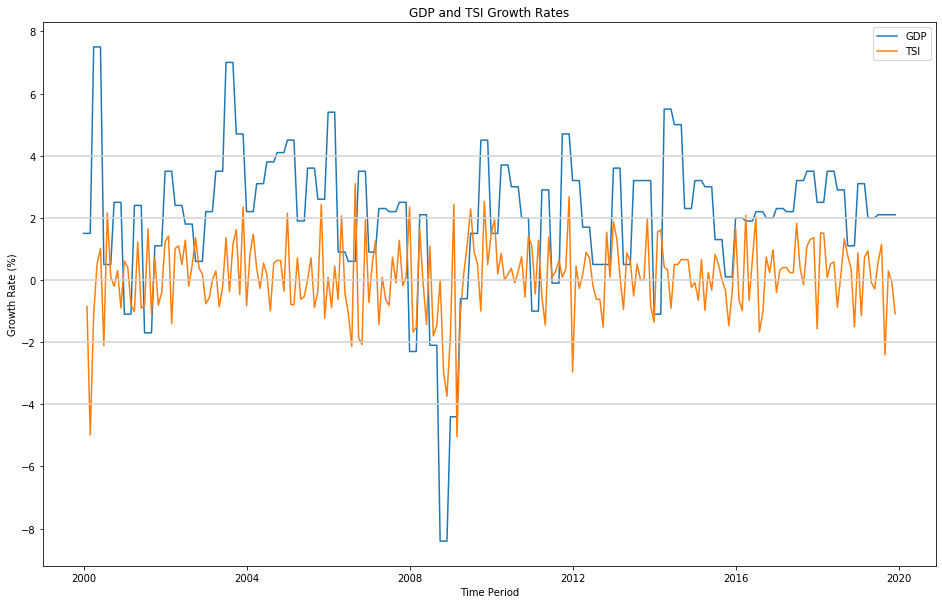

In [12]:
# Plot some of the data.  You can add in different columns from the dataset by uncommenting.
#plt.plot(merged_data['OBS_DATE'], merged_data['RAIL_FRT_PCT']*100.0, label='Rail Frt')
plt.plot(merged_data['OBS_DATE'], merged_data['Real_gdp_qtr_growth']*100.0, label='GDP')
#plt.plot(merged_data['OBS_DATE'], merged_data['RAIL_INTERMOD_PCT']*100.0, label='Rail Intermod')
#plt.plot(merged_data['OBS_DATE'], merged_data['WATERBORNE_PCT']*100.0, label='Water')
#plt.plot(merged_data['OBS_DATE'], merged_data['TRUCK_PCT']*100.0, label='Truck')
#plt.plot(merged_data['OBS_DATE'], merged_data['AIR_RTMFM_PCT']*100.0, label='Air and Mail Frt')
plt.plot(merged_data['OBS_DATE'], merged_data['TSI_PCT']*100.0, label='TSI')
plt.title('GDP and TSI Growth Rates')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Time Period')
plt.legend()
plt.axhline(-4, 0, 250, c='lightgrey')
plt.axhline(-2, 0, 250, c='lightgrey')
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)

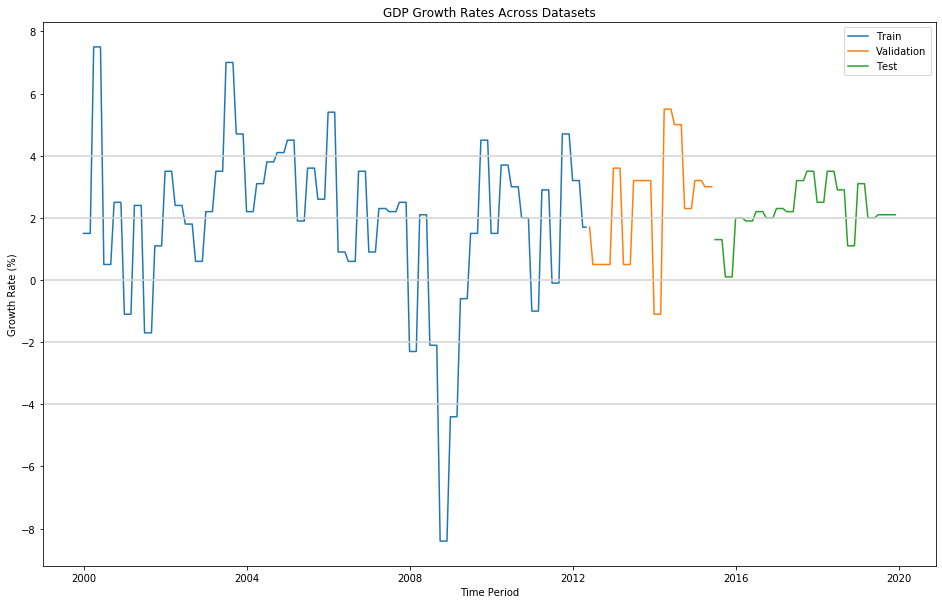

In [13]:
# Examine the GDP growth rate over all of our data. Color code the values that are in the
# training, validation, and test data sets.

plt.plot(merged_data.iloc[:train_row_count]['OBS_DATE'], 
         merged_data.iloc[:train_row_count]['Real_gdp_qtr_growth']*100.0, Label="Train")
plt.plot(merged_data.iloc[train_row_count:train_row_count + val_row_count]['OBS_DATE'], 
         merged_data.iloc[train_row_count:train_row_count + val_row_count]['Real_gdp_qtr_growth']*100.0, Label="Validation")
plt.plot(merged_data.iloc[train_row_count + val_row_count:]['OBS_DATE'], 
        merged_data.iloc[train_row_count + val_row_count:]['Real_gdp_qtr_growth']*100.0, Label="Test")
plt.title('GDP Growth Rates Across Datasets')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Time Period')
#plt.xticks(np.arange(2000, 2020,step=2))
plt.legend()
plt.axhline(-4, 0, 250, c='lightgrey')
plt.axhline(-2, 0, 250, c='lightgrey')
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)
#merged_data

We can see in the chart above that the GDP growth rate varies a lot more in the training data set then it does in the validation set.  And, the validation set has more variance then the test set.  

Below, we calculate the standard deviation for the output values for each data set.

In [14]:
y_train_std = merged_data.iloc[:train_row_count]['Real_gdp_qtr_growth'].std(axis=0)
print('y_train_std: {0:0.3f}'.format(y_train_std))

y_val_std = merged_data.iloc[train_row_count:train_row_count + val_row_count]['Real_gdp_qtr_growth'].std(axis=0)
print('y_val_std: {0:0.3f}'.format(y_val_std))

y_test_std = merged_data.iloc[train_row_count + val_row_count:]['Real_gdp_qtr_growth'].std(axis=0)
print('y_test_std: {0:0.3f}'.format(y_test_std))


y_train_std: 0.027
y_val_std: 0.019
y_test_std: 0.008


## Normalize the Data

In [15]:
#Calculate the mean and standard deviation of the training data set.
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

#Normalize the training data set to have a mean of 0 and standard deviation of 1.
x_train_std = x_train - mean
x_train_std = x_train_std / std

#Normalize the validation data set to have a mean of 0 and standard deviation of 1.
x_val_std = x_val - mean
x_val_std = x_val_std / std

#Normalize the test data set to have a mean of 0 and standard deviation of 1.
x_test_std = x_test - mean
x_test_std = x_test_std / std

In [16]:
#Examine the stats on the normalized training set
x_train_std.describe()

,RAIL_FRT_PCT,RAIL_INTERMOD_PCT,WATERBORNE_PCT,TRUCK_PCT,AIR_RTMFM_PCT,TSI_PCT
count,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02,1.490000e+02
mean,-1.490232e-18,-2.384372e-17,1.266697e-17,1.490232e-18,3.818720e-17,4.470697e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.294367e+00,-4.545280e+00,-2.703246e+00,-4.388498e+00,-3.056159e+00,-3.803338e+00
25%,-4.872035e-01,-4.580180e-01,-5.922187e-01,-5.500188e-01,-4.372516e-01,-6.368092e-01
50%,3.917056e-03,9.213551e-02,3.782409e-02,-5.243816e-02,-8.407633e-02,8.820267e-02
75%,5.530022e-01,5.286379e-01,4.182304e-01,6.334922e-01,4.231870e-01,6.200724e-01
max,2.616357e+00,4.761394e+00,2.886566e+00,2.378615e+00,7.039878e+00,2.263854e+00


## Setup a Neural Network Model Using Keras

In [17]:
# We will use this to run the model multiple times with varying input parameters.
# The neural network has the following structure:

# Dense layer -> Batch Normalization Layer -> 
# Dense Layer -> Batch Normalization Layer -> 
# Dense Layer with linear activation

# This function has input parameters for different regularization factors (penalty),
# regularization types (L1 and L2 supported), and number of dense layers.

def get_nn_model(penalty, reg_type, dense_layers, stdinput, learning_rate, 
                 x_train, x_train_std, y_train, x_val, x_val_std, y_val, verbose):
        
    if stdinput:
        xinput = x_train_std
        xval = x_val_std
    else:
        xinput = x_train
        xval = x_val
    
    nn_model = models.Sequential()
    
    if reg_type == "L2":
        nn_model.add(layers.Dense(dense_layers, activation='relu', input_shape=(xinput.shape[1],), kernel_regularizer=regularizers.l2(penalty)))
    else:
        nn_model.add(layers.Dense(dense_layers, activation='relu', input_shape=(xinput.shape[1],), kernel_regularizer=regularizers.l1(penalty)))
        
    #nn_model.add(layers.BatchNormalization())

    if reg_type == "L2":
        nn_model.add(layers.Dense(dense_layers, activation='relu', kernel_regularizer=regularizers.l2(penalty)))
    else:
        nn_model.add(layers.Dense(dense_layers, activation='relu', kernel_regularizer=regularizers.l1(penalty)))

    #nn_model.add(layers.BatchNormalization())
    nn_model.add(layers.Dense(1, activation='linear'))
    
    nn_model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    nn_model.optimizer.lr = learning_rate
    
    run_history = nn_model.fit(x=xinput, y=y_train.to_numpy(), epochs=215, validation_data=(xval, y_val), verbose=verbose)
    
    # Make training predictions so that we can calculate the standard deviation. This is so we can monitor if the
    # neural network is outputing a constant value, which can happen if the regularization penalty is too high.
    predictions_training = nn_model.predict(xinput)
    training_std = (predictions_training.std(axis=0)[0])*100.0
    
    return (nn_model, run_history, training_std)

In [18]:
# This facilitates running the model on a subset of the input data columns.  Can set all datasets here.
columnset = ['WATERBORNE_PCT', 'RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
x_train_input = x_train[columnset]
x_train_std_input = x_train_std[columnset]
x_val_input = x_val[columnset]
x_val_std_input = x_val_std[columnset]
x_test_input = x_test[columnset]
x_test_std_input = x_test_std[columnset]

In [19]:
# Inital run / single run of the model.

(trained_model, run_history, training_std) = get_nn_model(penalty=0.00001, reg_type='L2', dense_layers=32, stdinput=False, 
                                            learning_rate = 0.001, x_train=x_train_input, x_train_std=x_train_std_input, 
                                            y_train=y_train_rate, x_val=x_val_input, x_val_std=x_val_std_input, 
                                            y_val=y_val_rate, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 149 samples, validate on 37 samples
Epoch 1/215
149/149 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_absolute_error: 0.0253 - val_loss: 8.5904e-04 - val_mean_absolute_error: 0.0175
Epoch 2/215
149/149 [==============================] - 0s 40us/step - loss: 0.0013 - mean_absolute_error: 0.0208 - val_loss: 8.3380e-04 - val_mean_absolute_error: 0.0172
Epoch 3/215
149/149 [==============================] - 0s 40us/step - loss: 0.0012 - mean_absolute_error: 0.0204 - val_loss: 8.7192e-04 - val_mean_absolute_error: 0.0186
Epoch 4/215
149/149 [==============================] - 0s 60us/step - loss: 0.0012 - mean_absolute_error: 0.0202 - val_loss: 8.4183e-04 - val_mean_absolute_error: 0.0181
Epoch 5/215
149/149 [==============================] - 0s 47us/step - loss: 0.0011 - mean_absolute_error: 0.0190 - val_loss: 7.8118e-04 - val_mean_absolute_

149/149 [==============================] - 0s 67us/step - loss: 6.9807e-04 - mean_absolute_error: 0.0160 - val_loss: 6.4225e-04 - val_mean_absolute_error: 0.0173
Epoch 45/215
149/149 [==============================] - 0s 40us/step - loss: 6.8943e-04 - mean_absolute_error: 0.0158 - val_loss: 6.1470e-04 - val_mean_absolute_error: 0.0167
Epoch 46/215
149/149 [==============================] - 0s 54us/step - loss: 7.0184e-04 - mean_absolute_error: 0.0161 - val_loss: 6.3648e-04 - val_mean_absolute_error: 0.0175
Epoch 47/215
149/149 [==============================] - 0s 40us/step - loss: 6.8476e-04 - mean_absolute_error: 0.0158 - val_loss: 6.0655e-04 - val_mean_absolute_error: 0.0168
Epoch 48/215
149/149 [==============================] - 0s 54us/step - loss: 6.8138e-04 - mean_absolute_error: 0.0158 - val_loss: 6.2906e-04 - val_mean_absolute_error: 0.0174
Epoch 49/215
149/149 [==============================] - 0s 54us/step - loss: 6.7623e-04 - mean_absolute_error: 0.0158 - val_loss: 6.2069e-

Epoch 91/215
149/149 [==============================] - 0s 47us/step - loss: 5.9566e-04 - mean_absolute_error: 0.0153 - val_loss: 5.5136e-04 - val_mean_absolute_error: 0.0166
Epoch 92/215
149/149 [==============================] - 0s 54us/step - loss: 6.0554e-04 - mean_absolute_error: 0.0157 - val_loss: 5.8215e-04 - val_mean_absolute_error: 0.0175
Epoch 93/215
149/149 [==============================] - 0s 47us/step - loss: 6.0153e-04 - mean_absolute_error: 0.0153 - val_loss: 5.4073e-04 - val_mean_absolute_error: 0.0160
Epoch 94/215
149/149 [==============================] - 0s 40us/step - loss: 5.8070e-04 - mean_absolute_error: 0.0151 - val_loss: 6.0031e-04 - val_mean_absolute_error: 0.0178
Epoch 95/215
149/149 [==============================] - 0s 47us/step - loss: 6.1464e-04 - mean_absolute_error: 0.0161 - val_loss: 5.8848e-04 - val_mean_absolute_error: 0.0176
Epoch 96/215
149/149 [==============================] - 0s 40us/step - loss: 6.0332e-04 - mean_absolute_error: 0.0156 - val_l

149/149 [==============================] - 0s 54us/step - loss: 5.4596e-04 - mean_absolute_error: 0.0151 - val_loss: 5.5154e-04 - val_mean_absolute_error: 0.0170
Epoch 138/215
149/149 [==============================] - 0s 54us/step - loss: 5.4227e-04 - mean_absolute_error: 0.0151 - val_loss: 5.3166e-04 - val_mean_absolute_error: 0.0165
Epoch 139/215
149/149 [==============================] - 0s 47us/step - loss: 5.4365e-04 - mean_absolute_error: 0.0150 - val_loss: 5.3808e-04 - val_mean_absolute_error: 0.0166
Epoch 140/215
149/149 [==============================] - 0s 47us/step - loss: 5.4825e-04 - mean_absolute_error: 0.0151 - val_loss: 5.4004e-04 - val_mean_absolute_error: 0.0167
Epoch 141/215
149/149 [==============================] - 0s 54us/step - loss: 5.6671e-04 - mean_absolute_error: 0.0157 - val_loss: 5.6053e-04 - val_mean_absolute_error: 0.0173
Epoch 142/215
149/149 [==============================] - 0s 47us/step - loss: 5.5160e-04 - mean_absolute_error: 0.0152 - val_loss: 5.1

149/149 [==============================] - 0s 54us/step - loss: 5.1598e-04 - mean_absolute_error: 0.0148 - val_loss: 5.5622e-04 - val_mean_absolute_error: 0.0172
Epoch 184/215
149/149 [==============================] - 0s 47us/step - loss: 5.1878e-04 - mean_absolute_error: 0.0147 - val_loss: 5.2577e-04 - val_mean_absolute_error: 0.0164
Epoch 185/215
149/149 [==============================] - 0s 54us/step - loss: 5.1306e-04 - mean_absolute_error: 0.0148 - val_loss: 5.4516e-04 - val_mean_absolute_error: 0.0170
Epoch 186/215
149/149 [==============================] - 0s 47us/step - loss: 5.1411e-04 - mean_absolute_error: 0.0150 - val_loss: 5.2798e-04 - val_mean_absolute_error: 0.0166
Epoch 187/215
149/149 [==============================] - 0s 47us/step - loss: 5.1293e-04 - mean_absolute_error: 0.0148 - val_loss: 5.2960e-04 - val_mean_absolute_error: 0.0167
Epoch 188/215
149/149 [==============================] - 0s 40us/step - loss: 5.0949e-04 - mean_absolute_error: 0.0147 - val_loss: 5.5

## Evaluate Model Results

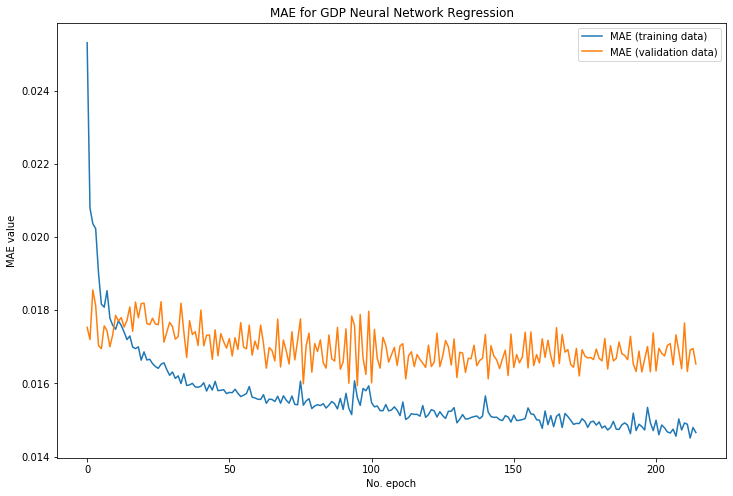

In [20]:
# Plot the mean absolute error for the training data and validation data over the epochs.
plt.plot(run_history.history['mean_absolute_error'], label='MAE (training data)') 
plt.plot(run_history.history['val_mean_absolute_error'], label='MAE (validation data)') 
plt.title('MAE for GDP Neural Network Regression')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [21]:
# Make predictions using training data.
predictions_training = trained_model.predict(x_train_input)

# Measure the mean absolute error for the training data.
training_mean_abs_error = mean_absolute_error(y_train_rate, predictions_training)
print('Training mean abs error: {0:0.3f}'.format(training_mean_abs_error))

# Check the standard deviation of the training predictions to make sure it is not predicting
# a constant value for every input. It will do this if the regularization is to high.
print('Training predictions std: {0:0.3f}'.format(training_std))  #(predictions_training.std(axis=0)[0])*100.0))

# Make predictions using training data.
predictions_val = trained_model.predict(x_val_input)

# Measure the mean absolute error for the validation data.
val_mean_abs_error = mean_absolute_error(y_val_rate.to_numpy(), predictions_val)
print('Validation mean abs error: {0:0.3f}'.format(val_mean_abs_error))

Training mean abs error: 0.014
Training predictions std: 1.586
Validation mean abs error: 0.017


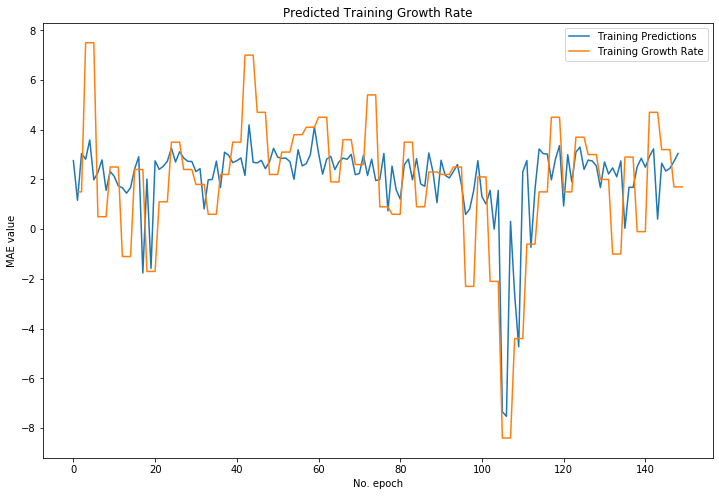

In [22]:
# Look at the predicted GDP growth rate vs the training growth rates
plt.plot(predictions_training*100.0, label='Training Predictions')
plt.plot(y_train_rate*100.0, label='Training Growth Rate')
plt.title('Predicted Training Growth Rate')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

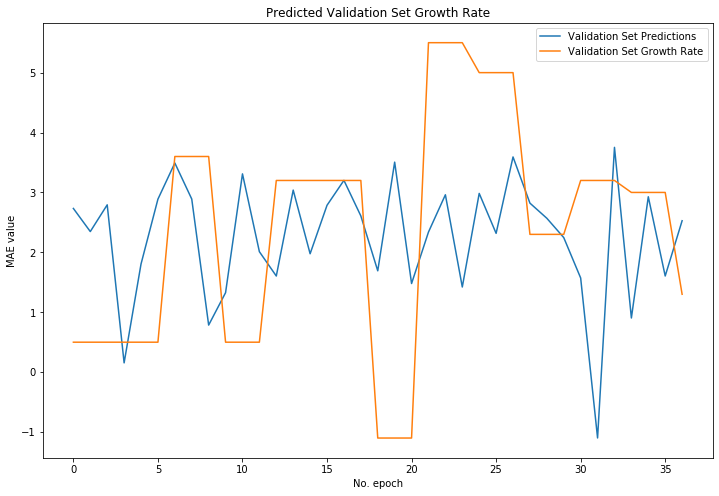

In [23]:
# Look at the predicted GDP growth rate vs the training growth rates
plt.plot(predictions_val*100.0, label='Validation Set Predictions')
plt.plot((y_val_rate.to_numpy())*100.0, label='Validation Set Growth Rate')
plt.title('Predicted Validation Set Growth Rate')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [24]:
# Make predictions using test data.
predictions_test = trained_model.predict(x_test_input)

# Measure the mean absolute error for the test data.
test_mean_abs_error = mean_absolute_error(y_test_rate, predictions_test)
print('Test mean abs error: {0:0.3f}'.format(test_mean_abs_error))

Test mean abs error: 0.009


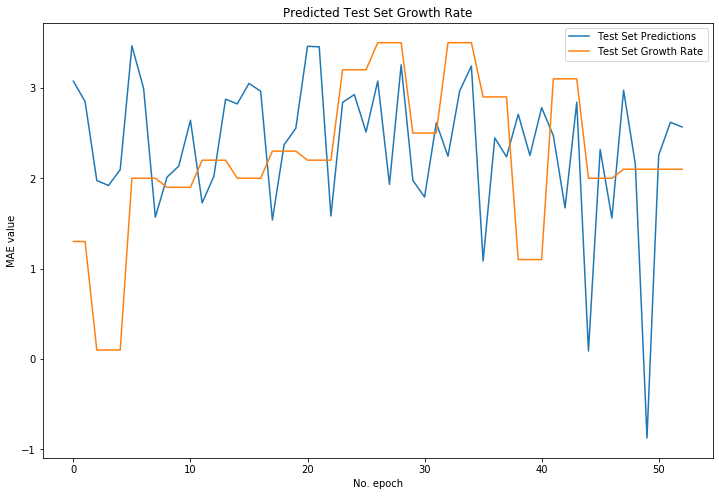

In [25]:
# Look at the predicted GDP growth rate vs the training growth rates
plt.plot(predictions_test*100.0, label='Test Set Predictions')
plt.plot((y_test_rate.to_numpy())*100.0, label='Test Set Growth Rate')
plt.title('Predicted Test Set Growth Rate')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [28]:
# Run a test case in the grid search.  This function will output a status update after each test case if
# print_real_time_output is True.  This function also appends a row to the "results" panda data frame 
# that is passed in for analysis later.

def run_test_case_nn(penalty, reg_type, dense_layers, stdinput, learning_rate, results, 
                     x_train, x_train_std, y_train, x_val, x_val_std, y_val, 
                     testcasecounter, print_real_time_output):
    
    test_case = '{6}: dense_layers={0}, reg={1}, penalty={2:0.07f}, lr={3:0.4f}, stdinput={4}, columns={5}'.format(
                                            in_dense_layers, in_reg_type, in_penalty, in_learning_rate, in_stdinput, columnset, testcasecounter)
    
    if print_real_time_output: print(test_case) # Print the test case if this indicator is True.

    (trained_model, run_history, training_std) = get_nn_model(penalty=penalty, reg_type=reg_type, dense_layers=dense_layers,
                                                stdinput=stdinput, learning_rate=learning_rate, 
                                                x_train=x_train[columnset],x_train_std=x_train_std[columnset], 
                                                y_train=y_train_rate, x_val=x_val[columnset], 
                                                x_val_std=x_val_std[columnset], y_val=y_val_rate, verbose=0)

    training_mae_min = np.min(run_history.history['mean_absolute_error']) # grab some min values from the run
    val_mae_min = np.min(run_history.history['val_mean_absolute_error'])

    test_case_result = 'Training mae min: {0:0.4f}, Val mae min: {1:0.4f}, Training std: {2:0.3f}\n'.format(
                                                                  training_mae_min, val_mae_min, training_std)
    if print_real_time_output: print(test_case_result)

    results = results.append(pd.Series([test_case, in_penalty, in_reg_type, in_dense_layers, in_learning_rate, columnset,
                                       in_stdinput, training_mae_min, val_mae_min, training_std], index=results.columns ), ignore_index=True)

    return (trained_model, results)

## Setup a Hyperparameter Grid Search

In [33]:
# Run the neural network model repeatedly, doing a grid search of selected hyperparameter values.
# Results will be written to a pandas dataframe so that we can easily analyze the results.
# We will also write output messages to the screen to monitor progress, but go get a beverage 
# of your choice after kicking this off.

#results = []
results = pd.DataFrame(columns=['Desc','Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate', 'Columns',
                                'StdInput', 'Training MAE Min', 'Val MAE Min', 'Training Std'])

columnsetall = ['WATERBORNE_PCT', 'RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
columnset1 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']
columnset2 = ['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
columnset3 = ['TRUCK_PCT', 'RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
columnset4 = ['TSI_PCT']

testcasecounter = 0
print_real_time_output = True # Set this to false if you don't want output while the grid search is running.

for in_dense_layers in [32, 64]:  #16, 32, 64
    for in_reg_type in ["L1", "L2"]: #"L1", "L2"
        for in_penalty in [0.0001, 0.00001, 0.000001]:  # 0.0001, 0.0000001
            for in_learning_rate in [0.001]:  #0.01, 0.001, 0.0006
                for in_stdinput in [False]:
                    for columnset in [columnsetall, columnset1, columnset2]: #columnsetall, columnset1, columnset2, columnset3, columnset4]:
                        testcasecounter += 1
                        
                        (trained_model, results) = run_test_case_nn(penalty=in_penalty, reg_type=in_reg_type, dense_layers=in_dense_layers,
                                                                    stdinput=in_stdinput, learning_rate=in_learning_rate, results=results,
                                                                    x_train=x_train[columnset],x_train_std=x_train_std[columnset], 
                                                                    y_train=y_train_rate, x_val=x_val[columnset], 
                                                                    x_val_std=x_val_std[columnset], y_val=y_val_rate,
                                                                    testcasecounter=testcasecounter, print_real_time_output=print_real_time_output)
                        

1: dense_layers=32, reg=L1, penalty=0.0001000, lr=0.0010, stdinput=False, columns=['WATERBORNE_PCT', 'RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
Training mae min: 0.0180, Val mae min: 0.0159, Training std: 0.000

2: dense_layers=32, reg=L1, penalty=0.0001000, lr=0.0010, stdinput=False, columns=['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT']
Training mae min: 0.0177, Val mae min: 0.0160, Training std: 0.000

3: dense_layers=32, reg=L1, penalty=0.0001000, lr=0.0010, stdinput=False, columns=['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
Training mae min: 0.0178, Val mae min: 0.0160, Training std: 0.000

4: dense_layers=32, reg=L1, penalty=0.0000100, lr=0.0010, stdinput=False, columns=['WATERBORNE_PCT', 'RAIL_FRT_PCT', 'RAIL_INTERMOD_PCT', 'TRUCK_PCT', 'AIR_RTMFM_PCT', 'TSI_PCT']
Training mae min: 0.0162, Val mae min: 0.0156, Training std: 1.252

5: dense_layers=32, reg=L1, penalty=0.0000100, lr=0.0010, stdinput=False, columns=['RAIL_INTERMOD_PCT', 'AIR_RTMFM_PC

## Analyze the Hyperparameter Grid Search Results

In [34]:
# Sort the model runs in ascending order by the validation mean absolute value
results.sort_values('Training MAE Min', inplace=True)

# Take a look at the model configurations in order with best at the top. 
results[['Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate', 'Columns', 'StdInput','Training MAE Min', 
         'Val MAE Min', 'Training Std']][results['Training MAE Min'] < 0.016]

,Penalty,Reg Type,Dense Layers,Learning Rate,Columns,StdInput,Training MAE Min,Val MAE Min,Training Std
33,0.000001,L2,64,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.008256,0.016206,2.207711
24,0.000001,L1,64,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.010495,0.016243,1.997864
15,0.000001,L2,32,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.010792,0.015000,1.963859
6,0.000001,L1,32,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.011048,0.017257,1.920925
30,0.000010,L2,64,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.012038,0.015247,1.791485
12,0.000010,L2,32,0.001,"[WATERBORNE_PCT, RAIL_FRT_PCT, RAIL_INTERMOD_P...",False,0.013033,0.015658,1.710624
35,0.000001,L2,64,0.001,"[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT]",False,0.013894,0.016199,1.740143
17,0.000001,L2,32,0.001,"[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT]",False,0.014515,0.016294,1.617447
8,0.000001,L1,32,0.001,"[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT]",False,0.014756,0.016194,1.619956
26,0.000001,L1,64,0.001,"[RAIL_INTERMOD_PCT, AIR_RTMFM_PCT, TSI_PCT]",False,0.014920,0.015836,1.546024


In [ ]:
# Write the results to an Excel file.
#results.to_excel('gdp_output_20200703.xlsx')

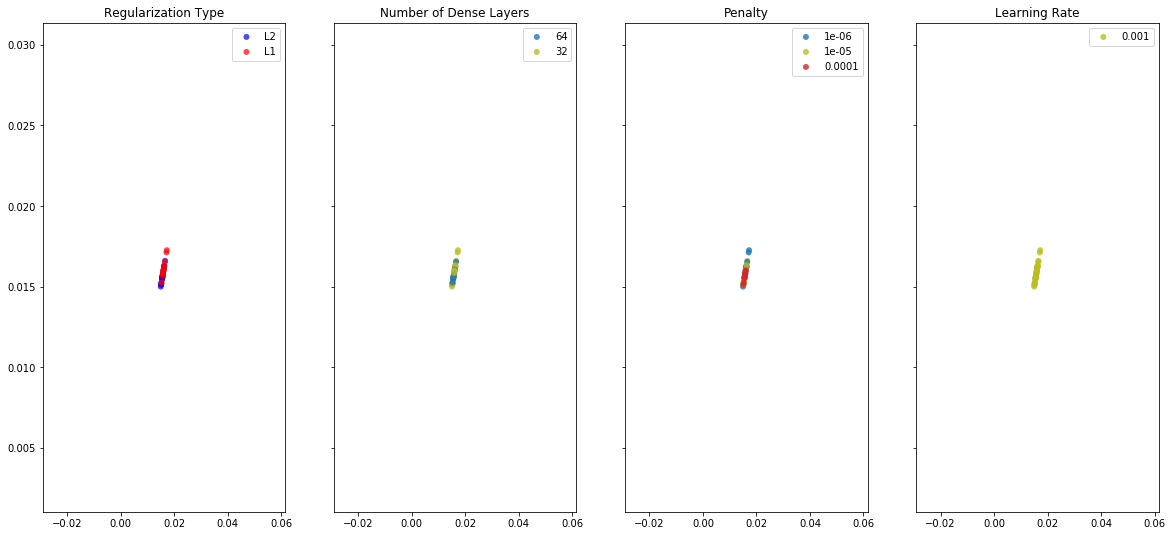

In [35]:
# Create scatter plots for the hyperparameter values.  I am color coding the points for each parameter value on each plot.
# The x and y axis are both the validation mean absolute error.
# This is done to help with visualizing what parameter values scored better.

regcolors = ("red", "blue")
regtype = ("L1", "L2") 

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)

for ind in results.index:
    regtype_val = results['Reg Type'][ind]
    axs[0].scatter(results['Val MAE Min'][ind], results['Val MAE Min'][ind], 
               c=regcolors[regtype.index(regtype_val)],
               label=regtype_val, alpha=0.7, edgecolors='none')

handles, labels = axs[0].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[0].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
axs[0].set_title('Regularization Type')            #prevent duplicated labels in the legend.
    
densecolors = ("tab:red", "tab:olive", "tab:blue")
densetype = (16, 32, 64)
for ind in results.index:
    densetype_val = results['Dense Layers'][ind]
    #print(densetype_val)
    axs[1].scatter(results['Val MAE Min'][ind], results['Val MAE Min'][ind], 
               c=densecolors[densetype.index(densetype_val)], 
               label=densetype_val, alpha=0.8, edgecolors='none')
    
handles, labels = axs[1].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[1].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
#https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
axs[1].set_title('Number of Dense Layers')

#Penalty
penaltycolors = ("tab:red", "tab:olive", "tab:blue") #, "tab:orange", "tab:green",
                 #"tab:purple", "tab:brown", "tab:pink", "tab:cyan")       #("tab:red", "tab:olive", "tab:blue")       
penaltytype = (0.0001, 0.00001, 0.000001) #(0.1, 0.01, 0.001)
for ind in results.index:
    penaltytype_val = results['Penalty'][ind]
    axs[2].scatter(results['Val MAE Min'][ind], results['Val MAE Min'][ind],
                   c=penaltycolors[penaltytype.index(penaltytype_val)],
                   label=penaltytype_val, alpha=0.8, edgecolors='none')

handles, labels = axs[2].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[2].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
axs[2].set_title('Penalty')

#learninr Rate
# for in_learning_rate in [0.01, 0.001, 0.0006]
learnratecolors = ("tab:red", "tab:olive", "tab:blue")       
learnratetype = (0.01, 0.001, 0.0006)
for ind in results.index:
    learnratetype_val = results['Learning Rate'][ind]
    axs[3].scatter(results['Val MAE Min'][ind], results['Val MAE Min'][ind],
                   c=learnratecolors[learnratetype.index(learnratetype_val)],
                   label=learnratetype_val, alpha=0.8, edgecolors='none')

handles, labels = axs[3].get_legend_handles_labels() #This section of code builds a
by_label = dict(zip(labels, handles))           #unique list of the labels and then uses 
axs[3].legend(by_label.values(), by_label.keys())  #them to build the legend. This is neccessary to
                                               #prevent duplicated labels in the legend.
axs[3].set_title('Learning Rate')
    
#ax.legend(loc="upper left")
#fig = plt.gcf()
fig.set_size_inches(20,9)
#plt.show()

Based on the above charts and from looking at the data:
-  Reg Type = L2
-  Dense Layers = 32
-  Penalty = 0.00001
-  Learning Rate = 0.001
-  Use raw data instead of normalize data
-  For input features, use all columns, which were: "WATERBORNE_PCT", "RAIL_FRT_PCT", “TRUCK_PCT”, “RAIL_INTERMOD_PCT”, “AIR_RTMFM_PCT”, “TSI_PCT”